The goal of this notebook is to use historical data from a loan company to develop a model which is going to be able to determine whether a loan request should be approved or denied when the customer 

In [33]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
pd.set_option('display.max_columns', None)

In [34]:
import os
os.getcwd()

'c:\\Data_Science\\IH_Notebooks\\home_loan_approval'

In [35]:
train = pd.read_csv('c:/Data_Science/IH_Notebooks/home_loan_approval/loan_sanction_train.csv')
test = pd.read_csv('c:/Data_Science/IH_Notebooks/home_loan_approval/loan_sanction_test.csv')

train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [36]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [37]:
train['Married'] = train['Married'].fillna('No')
train['Dependents'] = train['Dependents'].fillna(0)
train['Self_Employed'] = train['Self_Employed'].fillna('No')
train['LoanAmount'] = train['LoanAmount'].fillna(train['LoanAmount'].mean())
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mean())
train['Credit_History'] = train['Credit_History'].fillna(0)


In [38]:
train = train.dropna()

In [39]:
num = train.select_dtypes(include='number')
cat = train.select_dtypes(exclude='number')

In [40]:
cat = cat.drop(columns='Loan_Status')

In [41]:
#chi2 correlation test for cat values

chi2_results = []

#for loop to iterate over cat features

for feature in cat:
    contingency_table = pd.crosstab(train[feature], train['Loan_Status'])

    _, p, _, _ = chi2_contingency(contingency_table)

    chi2_results.append({
        'Feature' : feature,
        'p-value' : p,
        'Significant (p < 0.05)' : p< 0.05 
    })

chi2_df = pd.DataFrame(chi2_results).sort_values(by='p-value')

print(chi2_df)

         Feature   p-value  Significant (p < 0.05)
6  Property_Area  0.002243                    True
2        Married  0.038668                    True
4      Education  0.052975                   False
3     Dependents  0.255940                   False
0        Loan_ID  0.480820                   False
1         Gender  0.708653                   False
5  Self_Employed  0.747003                   False


After running the chi2 test for all of the categorical values we can confirm that only 2 features have statistical meaning to the target:

- Property_Area
- Married

The rest of the features can be dropped to facilitate the learning phase of the model.

I'm going to proceed and create a correlation matrix but in order for me to do that I will need to encode the dataframe accordingly.

In [42]:
#dropping columns which are no longer needed

train = train.drop(columns=['Education', 'Dependents', 'Loan_ID', 'Gender', 'Self_Employed'])

train.sample(10)

,Married,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
488,Yes,4583,2083.000000,160.0,360.0,1.0,Semiurban,Y
611,Yes,8072,240.000000,253.0,360.0,1.0,Urban,Y
193,No,3858,0.000000,76.0,360.0,1.0,Semiurban,Y
392,Yes,2583,2115.000000,120.0,360.0,0.0,Urban,Y
428,Yes,2920,16.120001,87.0,360.0,1.0,Rural,Y
237,No,3463,0.000000,122.0,360.0,0.0,Urban,Y
262,No,3481,0.000000,155.0,36.0,1.0,Semiurban,N
410,No,3867,0.000000,62.0,360.0,1.0,Semiurban,N
393,Yes,1993,1625.000000,113.0,180.0,1.0,Semiurban,Y
501,No,3159,0.000000,100.0,360.0,1.0,Semiurban,Y


In [43]:
train.columns = train.columns.str.lower()

In [44]:
property_grouped = train.groupby('property_area')['applicantincome'].mean()
property_grouped

property_area
Rural        5507.805714
Semiurban    5261.035242
Urban        5152.095477
Name: applicantincome, dtype: float64

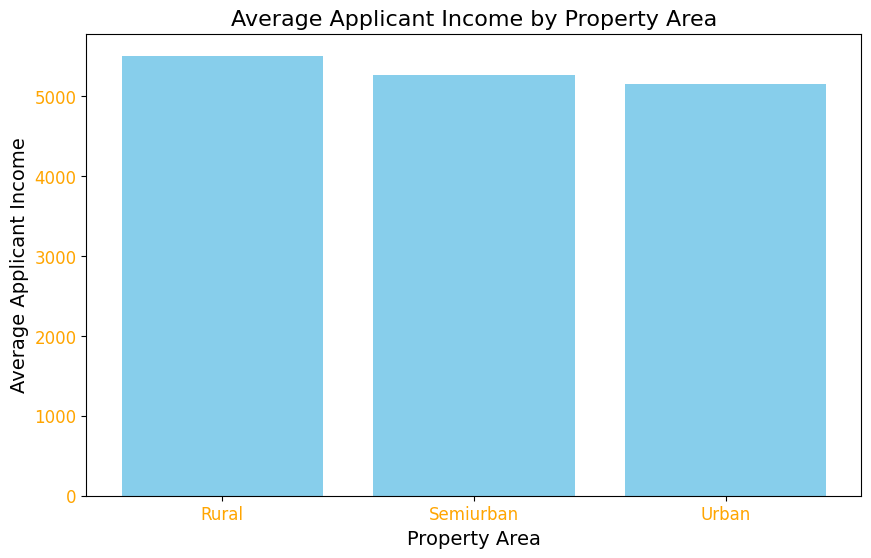

In [45]:
#plotting the grouped data

bars = property_grouped.index
height = property_grouped.values
x_pos = range(len(bars))

plt.figure(figsize=(10, 6))
plt.bar(x_pos, height, color='skyblue')

plt.xticks(x_pos, bars, color='orange', fontsize=12)
plt.yticks(color='orange', fontsize=12)
plt.xlabel('Property Area', fontsize=14)
plt.ylabel('Average Applicant Income', fontsize=14)
plt.title('Average Applicant Income by Property Area', fontsize=16)

plt.show()

In [46]:
property_filtered_rural = train.copy()

property_filtered_rural = property_filtered.loc[(property_filtered['property_area'] == 'Rural')]

In [47]:
property_filtered_semi = train.copy()
property_filtered_semi = property_filtered_semi.loc[(property_filtered_semi['property_area'] == 'Semiurban')]

In [48]:
property_filtered_urban = train.copy()
property_filtered_urban = property_filtered_urban.loc[(property_filtered_urban['property_area'] == 'Semiurban')]

In [49]:
crosstab_rural = pd.crosstab(property_filtered_rural['property_area'], property_filtered_rural['loan_status'])
crosstab_rural

loan_status,N,Y
property_area,,
Rural,67,108


In [50]:
crosstab_semi = pd.crosstab(property_filtered_semi['property_area'], property_filtered_semi['loan_status'])
crosstab_semi

loan_status,N,Y
property_area,,
Semiurban,52,175


In [51]:
crosstab_urban = pd.crosstab(property_filtered_urban['property_area'], property_filtered_urban['loan_status'])
crosstab_urban

loan_status,N,Y
property_area,,
Semiurban,52,175


The requests stemming from the rural area present a higher mean of income, followed by the semiurban and urban area.

Above we can see the bivariate analysis for all of the 3 areas.

In the future we might create a new numerical column for the train df which would be the result of the requestant income + the income of the partner.

In [53]:
#encoding the categorical features of train

married_dummies = pd.get_dummies(train["married"], prefix="married", dtype=int)
married_dummies

,married_No,married_Yes
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0
...,...,...
609,1,0
610,0,1
611,0,1
612,0,1


In [54]:
train = pd.concat([train, married_dummies], axis=1)

train

,married,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status,married_No,married_Yes
0,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,1,0
1,Yes,4583,1508.0,128.000000,360.0,1.0,Rural,N,0,1
2,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,0,1
3,Yes,2583,2358.0,120.000000,360.0,1.0,Urban,Y,0,1
4,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,1,0
...,...,...,...,...,...,...,...,...,...,...
609,No,2900,0.0,71.000000,360.0,1.0,Rural,Y,1,0
610,Yes,4106,0.0,40.000000,180.0,1.0,Rural,Y,0,1
611,Yes,8072,240.0,253.000000,360.0,1.0,Urban,Y,0,1
612,Yes,7583,0.0,187.000000,360.0,1.0,Urban,Y,0,1


In [55]:
loan_dummies = pd.get_dummies(train['loan_status'], prefix='loan', dtype=int)
loan_dummies

,loan_N,loan_Y
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1
...,...,...
609,0,1
610,0,1
611,0,1
612,0,1


In [56]:
train = pd.concat([train, loan_dummies], axis= 1)
train

,married,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status,married_No,married_Yes,loan_N,loan_Y
0,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,1,0,0,1
1,Yes,4583,1508.0,128.000000,360.0,1.0,Rural,N,0,1,1,0
2,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,0,1,0,1
3,Yes,2583,2358.0,120.000000,360.0,1.0,Urban,Y,0,1,0,1
4,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,No,2900,0.0,71.000000,360.0,1.0,Rural,Y,1,0,0,1
610,Yes,4106,0.0,40.000000,180.0,1.0,Rural,Y,0,1,0,1
611,Yes,8072,240.0,253.000000,360.0,1.0,Urban,Y,0,1,0,1
612,Yes,7583,0.0,187.000000,360.0,1.0,Urban,Y,0,1,0,1


In [57]:
urban_area_dummiers = pd.get_dummies(train['property_area'], dtype= int)
urban_area_dummiers

,Rural,Semiurban,Urban
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
609,1,0,0
610,1,0,0
611,0,0,1
612,0,0,1


In [58]:
train = pd.concat([train, urban_area_dummiers], axis=1)
train

,married,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status,married_No,married_Yes,loan_N,loan_Y,Rural,Semiurban,Urban
0,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,1,0,0,1,0,0,1
1,Yes,4583,1508.0,128.000000,360.0,1.0,Rural,N,0,1,1,0,1,0,0
2,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,0,1,0,1,0,0,1
3,Yes,2583,2358.0,120.000000,360.0,1.0,Urban,Y,0,1,0,1,0,0,1
4,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,No,2900,0.0,71.000000,360.0,1.0,Rural,Y,1,0,0,1,1,0,0
610,Yes,4106,0.0,40.000000,180.0,1.0,Rural,Y,0,1,0,1,1,0,0
611,Yes,8072,240.0,253.000000,360.0,1.0,Urban,Y,0,1,0,1,0,0,1
612,Yes,7583,0.0,187.000000,360.0,1.0,Urban,Y,0,1,0,1,0,0,1


In [59]:
train = train.drop(columns= ['married', 'property_area', 'loan_status'])
train

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,loan_N,loan_Y,Rural,Semiurban,Urban
0,5849,0.0,146.412162,360.0,1.0,1,0,0,1,0,0,1
1,4583,1508.0,128.000000,360.0,1.0,0,1,1,0,1,0,0
2,3000,0.0,66.000000,360.0,1.0,0,1,0,1,0,0,1
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,1,0,0,1
4,6000,0.0,141.000000,360.0,1.0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.000000,360.0,1.0,1,0,0,1,1,0,0
610,4106,0.0,40.000000,180.0,1.0,0,1,0,1,1,0,0
611,8072,240.0,253.000000,360.0,1.0,0,1,0,1,0,0,1
612,7583,0.0,187.000000,360.0,1.0,0,1,0,1,0,0,1


In [61]:
train.columns

Index(['applicantincome', 'coapplicantincome', 'loanamount',
       'loan_amount_term', 'credit_history', 'married_No', 'married_Yes',
       'loan_N', 'loan_Y', 'Rural', 'Semiurban', 'Urban'],
      dtype='object')

In [63]:
test.columns = test.columns.str.lower()

test = test.drop(columns=['loan_id', 'gender'])

In [67]:
test = test.dropna()

In [68]:
test

,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area
0,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
4,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban
5,Yes,0,Not Graduate,Yes,2165,3422,152.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...
361,Yes,1,Graduate,No,2269,2167,99.0,360.0,1.0,Semiurban
362,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban
363,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban
365,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural


In [69]:
#encoding the categorical features of train

married_test_dummies = pd.get_dummies(test["married"], prefix="married", dtype=int)
married_test_dummies

,married_No,married_Yes
0,0,1
1,0,1
2,0,1
4,1,0
5,0,1
...,...,...
361,0,1
362,0,1
363,0,1
365,0,1


In [71]:
urban_area_test_dummiers = pd.get_dummies(test['property_area'], dtype= int)
urban_area_test_dummiers

,Rural,Semiurban,Urban
0,0,0,1
1,0,0,1
2,0,0,1
4,0,0,1
5,0,0,1
...,...,...,...
361,0,1,0
362,0,0,1
363,0,0,1
365,1,0,0


In [72]:
test = pd.concat([test, married_test_dummies], axis=1)
test

,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,married_No,married_Yes
0,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,0,1
1,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,0,1
2,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,0,1
4,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,1,0
5,Yes,0,Not Graduate,Yes,2165,3422,152.0,360.0,1.0,Urban,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
361,Yes,1,Graduate,No,2269,2167,99.0,360.0,1.0,Semiurban,0,1
362,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban,0,1
363,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban,0,1
365,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural,0,1


In [73]:
test = pd.concat([test, urban_area_test_dummiers], axis=1)
test

,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,married_No,married_Yes,Rural,Semiurban,Urban
0,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,0,1,0,0,1
1,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,0,1,0,0,1
2,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,0,1,0,0,1
4,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,1,0,0,0,1
5,Yes,0,Not Graduate,Yes,2165,3422,152.0,360.0,1.0,Urban,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,Yes,1,Graduate,No,2269,2167,99.0,360.0,1.0,Semiurban,0,1,0,1,0
362,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban,0,1,0,0,1
363,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban,0,1,0,0,1
365,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural,0,1,1,0,0


In [75]:
train

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,loan_N,loan_Y,Rural,Semiurban,Urban
0,5849,0.0,146.412162,360.0,1.0,1,0,0,1,0,0,1
1,4583,1508.0,128.000000,360.0,1.0,0,1,1,0,1,0,0
2,3000,0.0,66.000000,360.0,1.0,0,1,0,1,0,0,1
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,1,0,0,1
4,6000,0.0,141.000000,360.0,1.0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.000000,360.0,1.0,1,0,0,1,1,0,0
610,4106,0.0,40.000000,180.0,1.0,0,1,0,1,1,0,0
611,8072,240.0,253.000000,360.0,1.0,0,1,0,1,0,0,1
612,7583,0.0,187.000000,360.0,1.0,0,1,0,1,0,0,1


In [76]:
test = test.drop(columns=['married', 'dependents', 'education', 'self_employed', 'property_area'])
test

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban
0,5720,0,110.0,360.0,1.0,0,1,0,0,1
1,3076,1500,126.0,360.0,1.0,0,1,0,0,1
2,5000,1800,208.0,360.0,1.0,0,1,0,0,1
4,3276,0,78.0,360.0,1.0,1,0,0,0,1
5,2165,3422,152.0,360.0,1.0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
361,2269,2167,99.0,360.0,1.0,0,1,0,1,0
362,4009,1777,113.0,360.0,1.0,0,1,0,0,1
363,4158,709,115.0,360.0,1.0,0,1,0,0,1
365,5000,2393,158.0,360.0,1.0,0,1,1,0,0


In [77]:
#moving the target on the right of the df

loan_y_col = train.pop('loan_Y')
train['loan_Y'] = loan_y_col

loan_n_col = train.pop('loan_N')
train['loan_N'] = loan_n_col

train

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y,loan_N
0,5849,0.0,146.412162,360.0,1.0,1,0,0,0,1,1,0
1,4583,1508.0,128.000000,360.0,1.0,0,1,1,0,0,0,1
2,3000,0.0,66.000000,360.0,1.0,0,1,0,0,1,1,0
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,0,1,1,0
4,6000,0.0,141.000000,360.0,1.0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.000000,360.0,1.0,1,0,1,0,0,1,0
610,4106,0.0,40.000000,180.0,1.0,0,1,1,0,0,1,0
611,8072,240.0,253.000000,360.0,1.0,0,1,0,0,1,1,0
612,7583,0.0,187.000000,360.0,1.0,0,1,0,0,1,1,0


In [78]:
#dropping loan_N as redundant

train = train.drop(columns='loan_N')

Now that I have completed the EDA, encoded and prepared the df, I can create a first baseline Logistic Regression model to see how it performs without any hyperparameters tuning.

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = train.drop(columns='loan_Y')
y = train['loan_Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline = LogisticRegression()

baseline.fit(X_train, y_train)


ModuleNotFoundError: No module named 'sklearn'